In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import qutip as qt

In [2]:
%load_ext autoreload
%autoreload 2

# Generic Floquet

In [3]:
from qutip import sigmax, sigmaz, floquet_modes

eps0 = 1.0 * 2 * np.pi
A = 0.1 * 2 * np.pi
omega = 0.02 *2* np.pi

H0 = eps0 / 2.0 * sigmaz()
H1 = A / 2.0 * sigmax()
args = {'w': omega}
H = [H0, [H1, 'sin(w * t)']]

In [154]:
T = 2*np.pi / omega
f_basis = qt.FloquetBasis(H, T, args=args)
# Calculate the Floquet modes and energies
f_energies = f_basis.e_quasi
f_modes_0 = f_basis.mode(0)
# f_modes_0, f_energies = floquet_modes(H, T, args)



In [155]:
f_energies/2/np.pi

array([-0.00124929,  0.00124929])

# Hamiltonians

## General Alice Bob Cavity Hamiltonian

Let the Hamiltonian for Alice (A), Bob (B), and a coupler mode (C), all modeled as cavity modes with annihilation operators $a$, $b$, and $c$ and frequencies $\omega_A$, $\omega_B$, $\omega_C$, be:

$$
H = \omega_A\, a^\dagger a + \omega_B\, b^\dagger b + \omega_C\, c^\dagger c  + g_{AC} (a^\dagger c + a c^\dagger) + g_{BC} (b^\dagger c + b c^\dagger)
$$

where:
- $a$, $b$, $c$ are annihilation operators for Alice, Bob, and the coupler mode,
- $a^\dagger$, $b^\dagger$, $c^\dagger$ are the corresponding creation operators,
- $g_{AC}$, $g_{BC}$ are couplings between Alice/Coupler and Bob/Coupler.

In [111]:
# Parameters for the general Alice-Bob-Cavity Hamiltonian (all units are in MHz)
omega_A = 2 * np.pi * 5e3      # Frequency of Alice's mode
omega_B = 2 * np.pi * 5.5e3      # Frequency of Bob's mode
omega_C = 2 * np.pi * 4e3      # Frequency of Coupler mode
g_AC = 2 * np.pi * 100         # Coupling between Alice and Coupler
g_BC = 2 * np.pi * 100         # Coupling between Bob and Coupler


## LINC Potential 
$$U = 2M^2E_J \cos{\phi_{ext}}\cos{\theta/M}$$
- $M$: Integer parameter related to the number of junctions or modes in the system  
- $E_J$: Josephson energy  
- $\phi_{ext}$: External flux phase  
- $\theta$: Collective phase variable, e.g., $\theta = \theta_{\mathrm{zpt}} (c + c^\dagger)$  
- $\theta_{\mathrm{zpt}} = (2E_C/E_L)^{1/4}$
- $U$: LINC potential energy

If we set $\phi_{ext} = \frac{\pi}{2} + \phi_{AC}$, then H becomes:
$$
U = 2M^2E_J \sin{\phi_{AC}}\cos{\theta/M}
$$



In [112]:
# Parameters for LINC potential (example values, adjust as needed)
M = 3                # Integer parameter (number of junctions/modes)
E_J = 2 * np.pi * 15e3    # Josephson energy (in appropriate units)
# phi_AC = np.pi / 4   # Phase variable (in radians)
E_C = 2 * np.pi * 100e3   # Charging energy
E_L = 2 * np.pi * 52.8    # Inductive energy


In [113]:
##

## Rough Strategy 
- Go TO RW frame of LINC, and cavities. Effective hamiltonian has the JC terms which gain exponential rotation and so does the E_J term 

- Now for each drive amplitude, find the resonant frequency of the beamsplitter
    - Do this simply be sweeping across different drive frequency and picking the frequency where we see a significant hybridization of alice and bob modes
- At the resonant frequency, extract the kerr using the higher levels (drive induced kerr shift)

In [114]:
from helpers import CouplerHamiltonian


In [156]:
coup_ham = CouplerHamiltonian(
    trunc=4,
    omega_A=omega_A,
    omega_B=omega_B,
    omega_C=omega_C,
    g_AC=g_AC,
    g_BC=g_BC,
    E_C=E_C,
    E_L=E_L,
    E_J=E_J
)

Initializing CouplerHamiltonian with truncation: 4
In lab frame


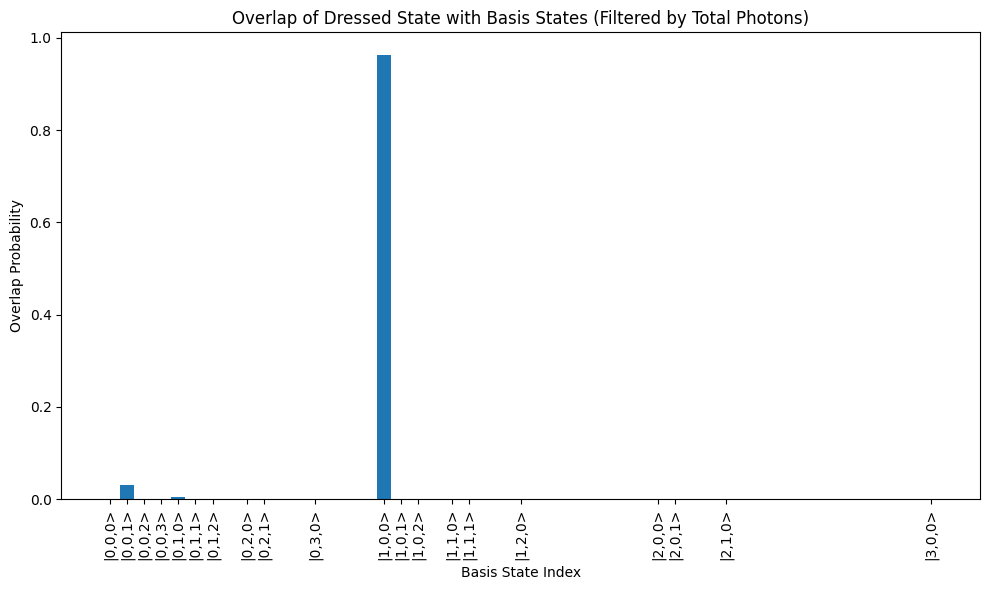

In [157]:
state_label = '|1,0,0>'
basis_idx = coup_ham.ket_to_basis_index(state_label)
dressed_idx = coup_ham.basis_to_dressed_mapping_dict[basis_idx]
coup_ham.plot_dressed_state_overlap(coup_ham.dressed_states[dressed_idx])

In [158]:
# get energies of alice and bob single photon dressed states
alice_energy = coup_ham.dressed_static_energies[coup_ham.basis_to_dressed_mapping_dict[coup_ham.ket_to_basis_index('|1,0,0>')]]
bob_energy = coup_ham.dressed_static_energies[coup_ham.basis_to_dressed_mapping_dict[coup_ham.ket_to_basis_index('|0,1,0>')]]
print(f"Alice single photon dressed state energy: {alice_energy/2/np.pi:.2f} MHz")
print(f"Bob single photon dressed state energy: {bob_energy/2/np.pi:.2f} MHz")
# Get the difference in energy
energy_diff = bob_energy - alice_energy
print(f"Energy difference between Alice and Bob single photon dressed states: {energy_diff/2/np.pi:.2f} MHz")

Alice single photon dressed state energy: 5032.53 MHz
Bob single photon dressed state energy: 5524.22 MHz
Energy difference between Alice and Bob single photon dressed states: 491.69 MHz


In [159]:
# calculate dressed state energy of 012 state
state_label = '|0,1,2>'
basis_idx = coup_ham.ket_to_basis_index(state_label)
dressed_idx = coup_ham.basis_to_dressed_mapping_dict[basis_idx]
dressed_energy = coup_ham.dressed_static_energies[dressed_idx]
print(f"Dressed state energy of {state_label}: {dressed_energy/2/np.pi:.2f} MHz")


Dressed state energy of |0,1,2>: 13393.63 MHz


In [150]:
983/980

1.0030612244897958

In [ ]:
# now get floquet modes 
omegad = 2 * np.pi * 500  # Floquet drive frequency
amp = 0.4
H0 = coup_ham.hamiltonian_static()
operator, time_func = coup_ham.linc_potential_operator()
H_fq = [H0, [operator, time_func]]
f_energies, f_modes = coup_ham.floquet_modes(H_fq, omegad, args={'phi_AC_amp': amp, 'omega': omegad})
dressed_to_floquet_mapping, floquet_to_dressed_mapping = coup_ham.dressed_to_floquet_mapping(f_modes)

/opt/anaconda3/envs/quantum/lib/python3.12/site-packages/qutip/solver/options.py:16: FutureWarning: Dedicated options class are no longer needed, options should be passed as dict to solvers.
  warnings.warn(


ValueError: QobjEvo term [Quantum object: dims=[[4, 4, 4], [4, 4, 4]], shape=(64, 64), type='oper', dtype=Dense, isherm=False
Qobj data =
[[-403235.49598661       0.          658783.96525403 ...       0.
        0.               0.        ]
 [      0.          528425.72234956       0.         ...       0.
        0.               0.        ]
 [ 658783.96525403       0.         1460086.94068573 ...       0.
        0.               0.        ]
 ...
 [      0.               0.               0.         ...  528425.72234956
        0.         1141047.29903166]
 [      0.               0.               0.         ...       0.
  1460086.94068573       0.        ]
 [      0.               0.               0.         ... 1141047.29903166
        0.          528425.72234956]], <function CouplerHamiltonian.linc_potential_operator.<locals>.coeff_func at 0x13df372e0>] has dims [[4, 4, 4], [4, 4, 4]] and shape (64, 64) but previous terms had dims [[5, 5, 5], [5, 5, 5]] and shape (125, 125).

In [161]:
operator.shape

(64, 64)

Dressed state index: 3
Floquet state index: 38
Overlaps with dressed states: [1.5342758038653832e-32, 0.05183859454861778, 1.690117796415595e-06, 0.45755180951635643, 9.755401224967762e-31, 2.7819695011353243e-31, 1.4011207405322312e-31, 2.4967988645222484e-30, 3.380073311284166e-30, 5.976314550476238e-31, 0.006578089908595435, 1.65420727460238e-06, 0.008353834594977187, 1.779588596995582e-08, 0.0011706681588494012, 0.0018993446659880467, 8.528713303315882e-08, 0.00022871236374511227, 1.0901352054732941e-31, 0.00012176063935732507, 0.0005702419314592763, 5.19140331477892e-31, 4.462697184406334e-32, 2.067750017051795e-31, 5.638902640939045e-32, 2.6636850244373006e-31, 6.216005151581058e-31, 5.678988811899261e-30, 3.812484864264953e-30, 1.2362619924993388e-30, 1.321197236201641e-30, 0.022019709769068585, 6.637164415999041e-32, 1.3529359383099925e-27, 0.3813199871107367, 7.669154946760961e-31, 0.0005456298276870672, 3.5183544654611436e-30, 0.023650027780460593, 0.038832247148791174, 1.620

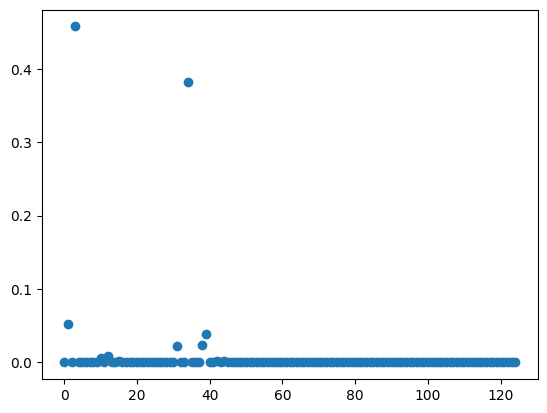

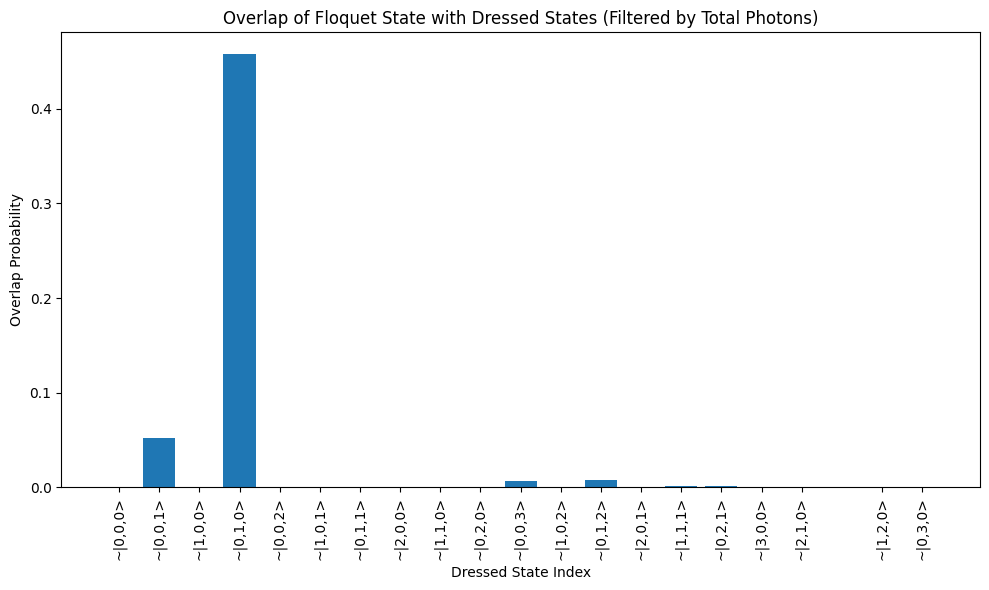

In [138]:
# map floquet modes to dressed modes 
floquet_state_to_plot = '|0,1,0>'  # Bob's state
# Find the index of associated dressed state and then apply the dressed to floquet mapping
dressed_idx = coup_ham.basis_to_dressed_mapping_dict[coup_ham.ket_to_basis_index(floquet_state_to_plot)]
print(f"Dressed state index: {dressed_idx}")
floquet_idx = dressed_to_floquet_mapping[dressed_idx]
print(f"Floquet state index: {floquet_idx}")
coup_ham.plot_floquet_state_overlap(f_modes[floquet_idx])

In [136]:
# find teh quasienergies of alice and bob floquet single photon states
alice_floquet_idx = dressed_to_floquet_mapping[coup_ham.basis_to_dressed_mapping_dict[coup_ham.ket_to_basis_index('|1,0,0>')]]
bob_floquet_idx = dressed_to_floquet_mapping[coup_ham.basis_to_dressed_mapping_dict[coup_ham.ket_to_basis_index('|0,1,0>')]]
alice_floquet_energy = f_energies[alice_floquet_idx]
bob_floquet_energy = f_energies[bob_floquet_idx]
print(f"Alice single photon Floquet state energy: {alice_floquet_energy/2/np.pi:.2f} MHz")
print(f"Bob single photon Floquet state energy: {bob_floquet_energy/2/np.pi:.2f} MHz")
# Get the difference in energy
energy_diff_floquet = bob_floquet_energy - alice_floquet_energy

Alice single photon Floquet state energy: 16.32 MHz
Bob single photon Floquet state energy: 160.59 MHz


3

In [131]:
H0

[Quantum object: dims=[[5, 5, 5], [5, 5, 5]], shape=(125, 125), type='oper', dtype=Dia, isherm=True
 Qobj data =
 [[     0.              0.              0.         ...      0.
        0.              0.        ]
  [     0.          25132.74122872      0.         ...      0.
        0.              0.        ]
  [     0.              0.          50265.48245744 ...      0.
        0.              0.        ]
  ...
  [     0.              0.              0.         ... 326725.63597334
        0.              0.        ]
  [     0.              0.              0.         ...      0.
   351858.37720206      0.        ]
  [     0.              0.              0.         ...      0.
        0.         376991.11843078]],
 [Quantum object: dims=[[5, 5, 5], [5, 5, 5]], shape=(125, 125), type='oper', dtype=Dia, isherm=True
  Qobj data =
  [[0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   ...
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 

In [123]:
operator

Quantum object: dims=[[5, 5, 5], [5, 5, 5]], shape=(125, 125), type='oper', dtype=Dense, isherm=True
Qobj data =
[[ 2.39846439e-05  0.00000000e+00 -1.03769820e-04 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00 -1.22768043e-04  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-1.03769820e-04  0.00000000e+00  6.10353204e-05 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  6.10353204e-05
   0.00000000e+00  3.20868271e-05]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   2.44679836e-05  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  3.20868271e-05
   0.00000000e+00 -3.32002383e-06]]

In [ ]:
s

In [97]:
coup_ham.generate_H0()/2/np.pi

Quantum object: dims=[[5, 5, 5], [5, 5, 5]], shape=(125, 125), type='oper', dtype=Dia, isherm=True
Qobj data =
[[    0.     0.     0. ...     0.     0.     0.]
 [    0.  4000.     0. ...     0.     0.     0.]
 [    0.     0.  8000. ...     0.     0.     0.]
 ...
 [    0.     0.     0. ... 52000.     0.     0.]
 [    0.     0.     0. ...     0. 56000.     0.]
 [    0.     0.     0. ...     0.     0. 60000.]]

In [98]:
quasienergies

array([-5.19649817e-06, -3.58720499e-06, -2.59428541e-06, -2.00326726e-06,
       -0.00000000e+00,  8.34470853e-06,  3.43124620e-05,  3.43124687e-05,
        8.64484887e-05,  1.81275238e-04,  1.81275253e-04,  3.42381709e-04,
        6.02403460e-04,  6.02403475e-04,  1.00531485e-03,  1.00531485e-03,
        1.60904643e-03,  1.60904643e-03,  1.60904645e-03,  2.48843985e-03,
        2.48843987e-03,  3.73855107e-03,  3.73855107e-03,  3.73855110e-03,
        5.47831127e-03,  5.47831128e-03,  7.85455528e-03,  7.85455528e-03,
        7.85455528e-03,  1.10464261e-02,  1.10464261e-02,  1.10464261e-02,
        1.52701662e-02,  1.52701662e-02,  1.52701662e-02,  1.52701662e-02,
        2.07843050e-02,  2.07843050e-02,  2.07843050e-02,  2.78952564e-02,
        2.78952565e-02,  2.78952565e-02,  2.78952565e-02,  3.69633397e-02,
        3.69633397e-02,  4.84092411e-02,  4.84092411e-02,  4.84092411e-02,
        4.84092411e-02,  6.27209379e-02,  6.27209379e-02,  6.27209379e-02,
        6.27209379e-02,  

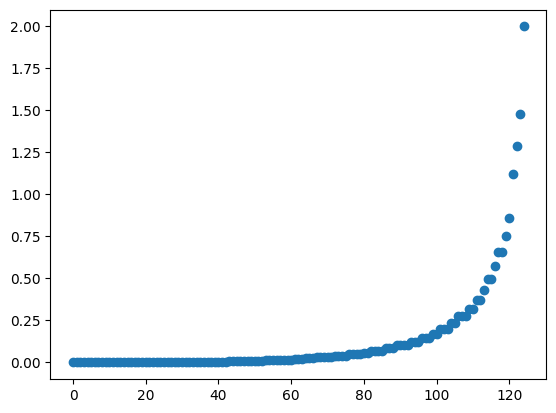

In [99]:
plt.plot(quasienergies/2/np.pi, 'o')

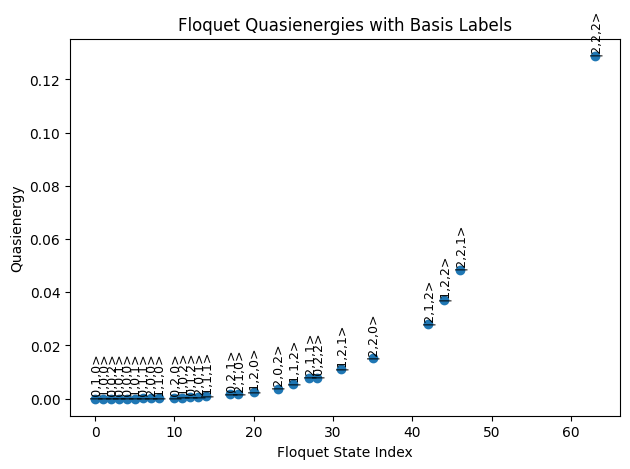

In [100]:
coup_ham.plot_floquet_energies( states, quasienergies)#, title="LINC potential quasienergies")

In [101]:
energies, modes = coup_ham.compute_states_over_floquet_period(omega =omegad, H = H, num_points = 10)


Computing Floquet states: 100%|██████████| 10/10 [00:23<00:00,  2.31s/it]


5
25
2
1
0
26
6
50
30
3
10
27
7
51
31
75
4
11
55
28
35
15
8
52
76
32
100
56
12
29
80
36
53
16
9
60
77
40
33
13
101
20
57
81
37
17
61
105
54
78
41
85
34
102
65
58
21
14
82
45
38
18
106
62
42
79
86
103
66
110
59
22
90
83
46
39
19
70
107
63
43
87
104
67
23
111
91
84
47
108
115
71
64
44
95
88
68
112
24
48
92
109
116
72
96
89
120
113
69
93
49
73
117
97
114
121
94
118
74
98
122
119
99
123
124


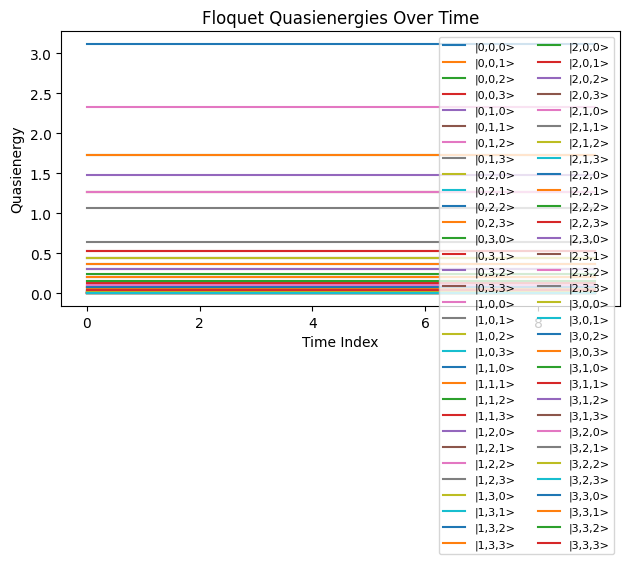

In [102]:
coup_ham.plot_floquet_energies_over_period(energies, modes, max_photons_per_mode=3)

In [ ]:
num_points = len(energies)
keys = big_mapping_list[0].keys()
en_for_state = np.zeros(( len(keys), num_points))
for j, key in enumerate(keys):
    en_for_state[j, :] = [big_mapping_list[i][key] for i in range(num_points)]




{0: 66,
 1: 61,
 2: 91,
 3: 36,
 4: 17,
 5: 42,
 6: 31,
 7: 16,
 8: 37,
 9: 32,
 10: 96,
 11: 27,
 12: 2,
 13: 117,
 14: 87,
 15: 112,
 16: 82,
 17: 107,
 18: 77,
 19: 102,
 20: 22,
 21: 47,
 22: 72,
 23: 122,
 24: 97,
 25: 26,
 26: 1,
 27: 1,
 28: 56,
 29: 61,
 30: 6,
 31: 86,
 32: 51,
 33: 76,
 34: 11,
 35: 41,
 36: 56,
 37: 16,
 38: 81,
 39: 91,
 40: 86,
 41: 101,
 42: 106,
 43: 96,
 44: 71,
 45: 111,
 46: 46,
 47: 21,
 48: 92,
 49: 37,
 50: 12,
 51: 17,
 52: 42,
 53: 7,
 54: 12,
 55: 37,
 56: 62,
 57: 27,
 58: 32,
 59: 57,
 60: 52,
 61: 87,
 62: 90,
 63: 121,
 64: 80,
 65: 77,
 66: 70,
 67: 45,
 68: 20,
 69: 95,
 70: 112,
 71: 107,
 72: 117,
 73: 78,
 74: 3,
 75: 28,
 76: 33,
 77: 8,
 78: 38,
 79: 53,
 80: 13,
 81: 64,
 82: 63,
 83: 78,
 84: 68,
 85: 83,
 86: 18,
 87: 43,
 88: 18,
 89: 93,
 90: 120,
 91: 39,
 92: 94,
 93: 84,
 94: 79,
 95: 19,
 96: 14,
 97: 9,
 98: 39,
 99: 44,
 100: 4,
 101: 29,
 102: 34,
 103: 54,
 104: 59,
 105: 63,
 106: 88,
 107: 98,
 108: 103,
 109: 73,
 110: